In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Find all image with name pose*.png
image_paths = glob.glob("pose*.png")
image_paths

['pose0005.png',
 'pose0003.png',
 'pose0002.png',
 'pose0000.png',
 'pose0004.png',
 'pose0001.png']

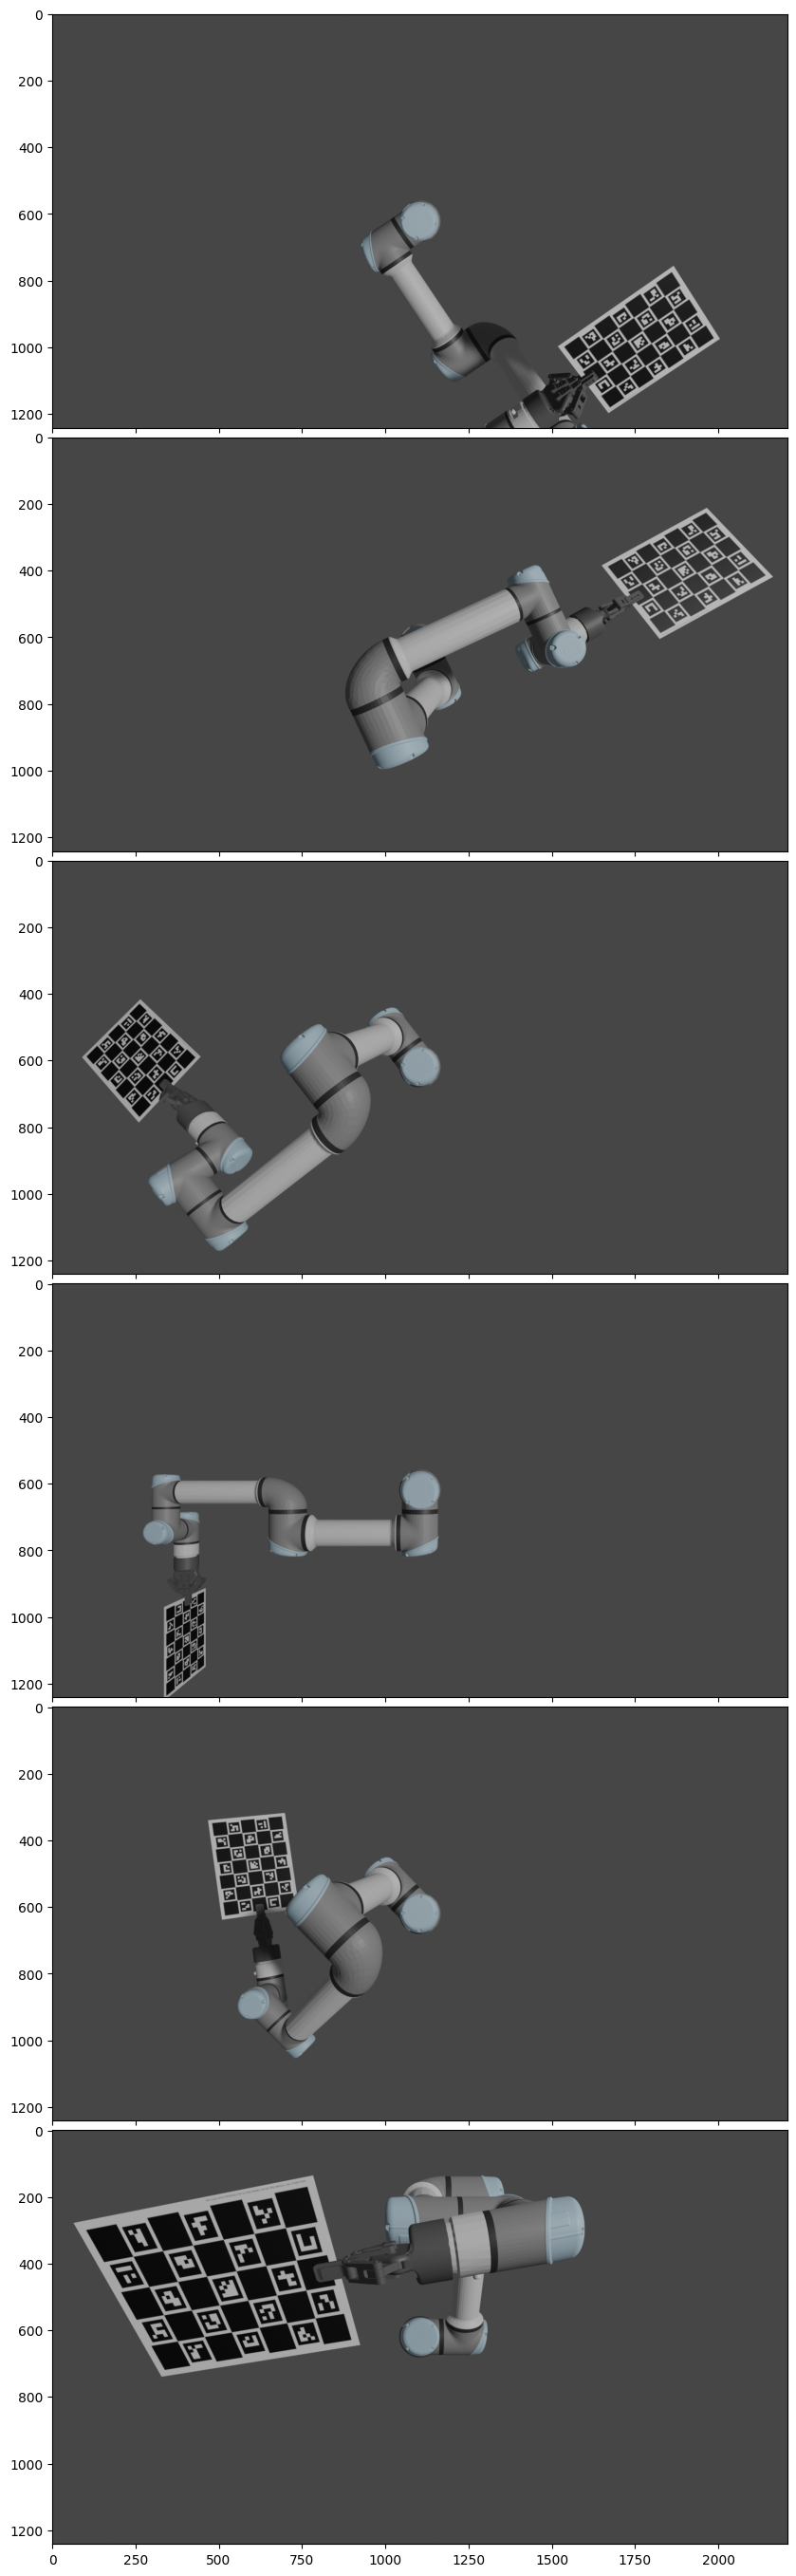

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid
images = [cv2.imread(image_path) for image_path in image_paths]

def plot_image_grid(images_bgr, cols=1, scale=4.0):
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_bgr]
    rows = int(np.ceil(len(images) / cols))

    fig = plt.figure(figsize=(10, 100))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(rows, cols),
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    # _, axs = plt.subplots(rows, cols, figsize=(10, 60))
    for i, ax in enumerate(grid):
        ax.imshow(images[i])
    plt.show()

plot_image_grid(images)

In [4]:
from airo_dataset_tools.camera_intrinsics import CameraIntrinsics

# Load camera intrinsics from file
intrinsics_saved = CameraIntrinsics.parse_file("camera_intrinsics.json")

def intrinsics_to_K_matrix(intrinsics: CameraIntrinsics):
    fx = intrinsics.focal_lengths_in_pixels.fx
    fy = intrinsics.focal_lengths_in_pixels.fy
    cx = intrinsics.principal_point_in_pixels.cx
    cy = intrinsics.principal_point_in_pixels.cy
    return np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

K = intrinsics_to_K_matrix(intrinsics_saved)

with np.printoptions(precision=3, suppress=True):
    print(K)

[[1060.    0. 1104.]
 [   0. 1060.  621.]
 [   0.    0.    1.]]


In [5]:
from airo_camera_toolkit.calibration.fiducial_markers import (
    AIRO_DEFAULT_ARUCO_DICT,
    AIRO_DEFAULT_CHARUCO_BOARD,
    detect_aruco_markers,
    get_poses_of_aruco_markers,
    detect_charuco_corners,
    get_pose_of_charuco_board,
    visualize_aruco_detections,
    draw_frame_on_image,
    visualize_charuco_detection,
)

aruco_dict = AIRO_DEFAULT_ARUCO_DICT
charuco_board = AIRO_DEFAULT_CHARUCO_BOARD

def draw_aruco_detections(image, intrinsics):
    # print(intrinsics)
    aruco_result = detect_aruco_markers(image, aruco_dict)

    charuco_result = None
    if aruco_result:
        charuco_result = detect_charuco_corners(image, aruco_result, charuco_board)
        if charuco_result:
            charuco_pose = get_pose_of_charuco_board(charuco_result, charuco_board, intrinsics)

    if aruco_result:
        image = visualize_aruco_detections(image, aruco_result)


    if charuco_result:
        image = visualize_charuco_detection(image, charuco_result)
        if charuco_pose is not None:
            image = draw_frame_on_image(image, charuco_pose, intrinsics)
    return image

In [6]:
images_with_detections = [draw_aruco_detections(image, K) for image in images]

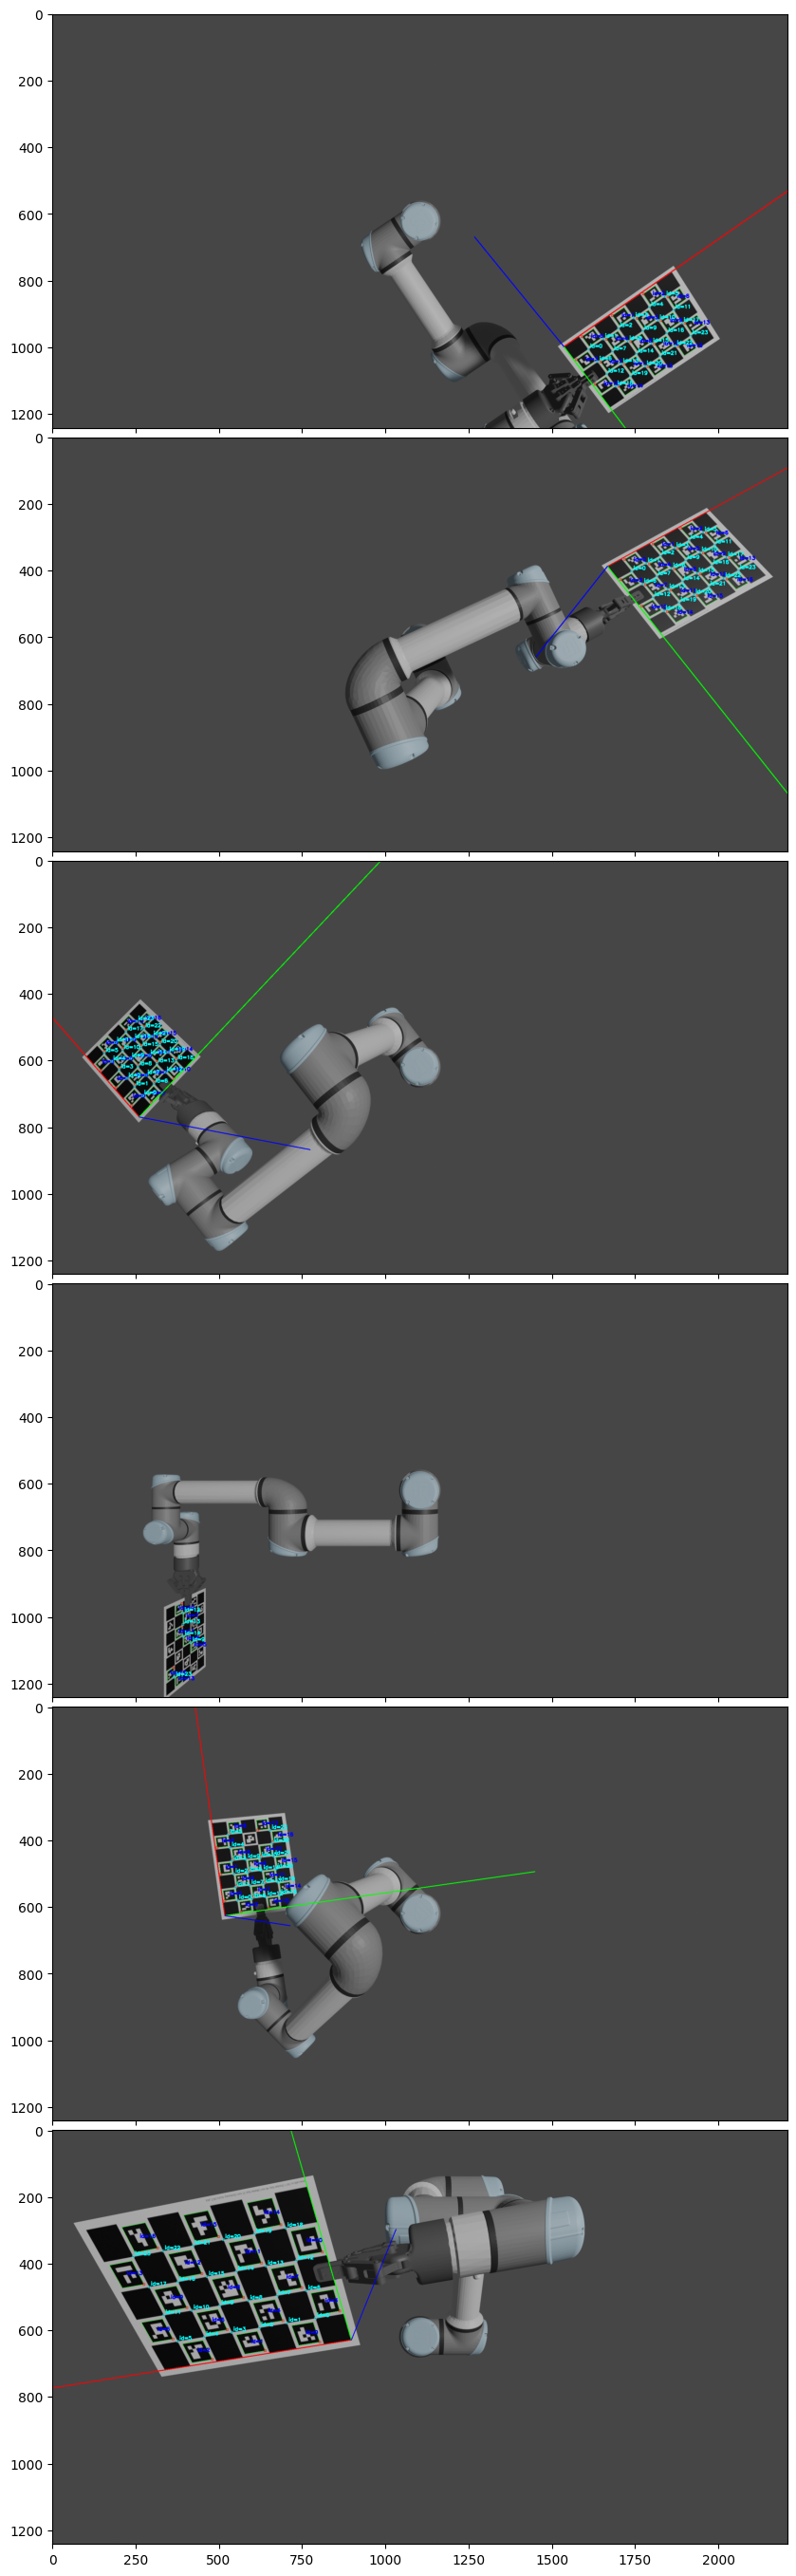

In [7]:
plot_image_grid(images_with_detections)